Importing of Datasets

To Run

pip install pandas
pip install geopandas
pip install matplotlib
pip install numpy
pip install sklearn
pip install ast

In [264]:
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt

file_path = 'transit-gtfs-stops.csv'
busStopsData = pd.read_csv(file_path)

file_path = 'civic-addresses.csv'
houseAddressData = pd.read_csv(file_path)

file_path_houses = 'civic-addresses.csv'  
file_path_bus_stops = 'transit-gtfs-stops.csv'     

house_address_data = pd.read_csv(file_path_houses)
bus_stops_data = pd.read_csv(file_path_bus_stops)

def split_lat_lon(df, column_name):
    coords = df[column_name].str.split(',', expand=True)
    coords.columns = ['latitude', 'longitude']
    coords['latitude'] = coords['latitude'].astype(float)
    coords['longitude'] = coords['longitude'].astype(float)
    return coords

house_address_data[['latitude', 'longitude']] = split_lat_lon(house_address_data, 'LongLat')
bus_stops_data[['latitude', 'longitude']] = split_lat_lon(bus_stops_data, 'LongLat')
house_coords_rad = np.radians(house_address_data[['latitude', 'longitude']].values)
bus_stop_coords_rad = np.radians(bus_stops_data[['latitude', 'longitude']].values)
tree = BallTree(bus_stop_coords_rad, metric='haversine')
distances, indices = tree.query(house_coords_rad, k=1)  
distances_meters = distances * 6371000
house_address_data['distance_to_nearest_bus_stop_m'] = distances_meters.flatten()

distance_stats = house_address_data['distance_to_nearest_bus_stop_m'].describe()

distance_stats_df = distance_stats.to_frame(name='Distance to Nearest Bus Stop (meters)')
print(distance_stats_df)


       Distance to Nearest Bus Stop (meters)
count                           72778.000000
mean                              628.618395
std                              2124.725674
min                                 5.357146
25%                                82.977852
50%                               140.390975
75%                               239.673659
max                             26266.238154


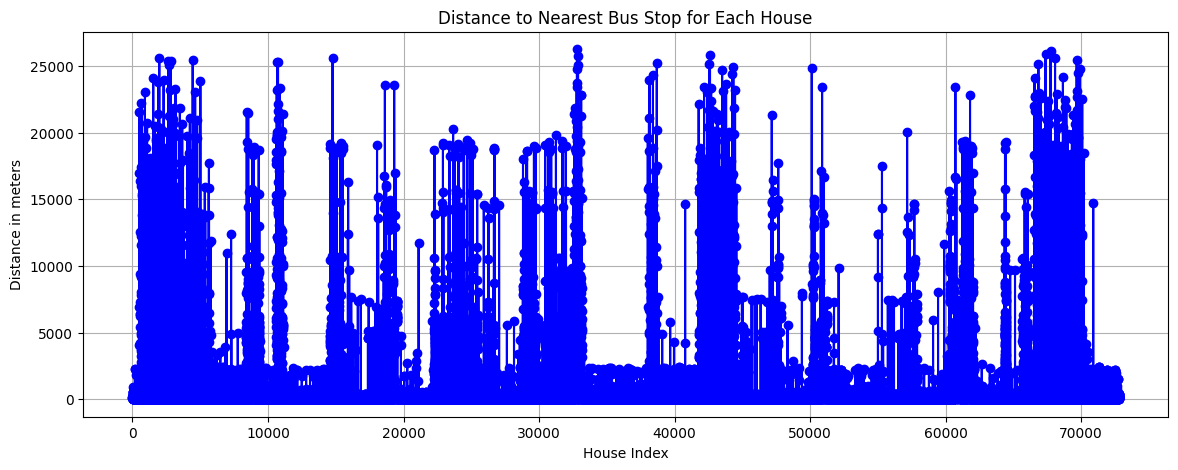

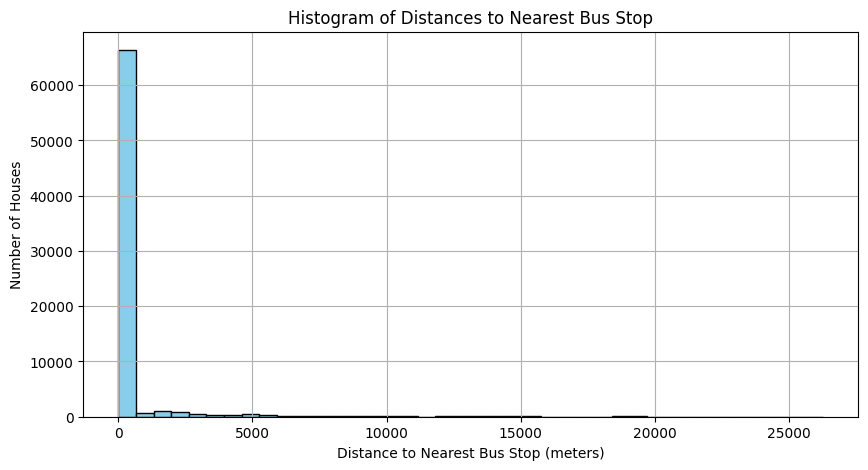

In [265]:
plt.figure(figsize=(14, 5))  
plt.plot(house_address_data.index, house_address_data['distance_to_nearest_bus_stop_m'], 'o-', color='blue')
plt.title('Distance to Nearest Bus Stop for Each House')
plt.xlabel('House Index')
plt.ylabel('Distance in meters')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))  
plt.hist(house_address_data['distance_to_nearest_bus_stop_m'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Distances to Nearest Bus Stop')
plt.xlabel('Distance to Nearest Bus Stop (meters)')
plt.ylabel('Number of Houses')
plt.grid(True)
plt.show()

In [266]:
num_bins = 40
counts, bin_edges = np.histogram(house_address_data['distance_to_nearest_bus_stop_m'], bins=num_bins)
bin_intervals = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
total_houses = house_address_data.shape[0]
percentages = (counts / total_houses) * 100
histogram_data_intervals = pd.DataFrame({
    'Bin_Interval': bin_intervals,
    'Count': counts,
    'Percentage': percentages
})

histogram_data_intervals

,Bin_Interval,Count,Percentage
0,5.36 - 661.88,66354,91.173157
1,661.88 - 1318.40,661,0.908242
2,1318.40 - 1974.92,961,1.320454
3,1974.92 - 2631.45,769,1.056638
4,2631.45 - 3287.97,423,0.581220
5,3287.97 - 3944.49,384,0.527632
6,3944.49 - 4601.01,344,0.472670
7,4601.01 - 5257.53,553,0.759845
8,5257.53 - 5914.06,383,0.526258
9,5914.06 - 6570.58,209,0.287175


Shows that 91% of the houses in kingston are within 5-661 meters of a bus station

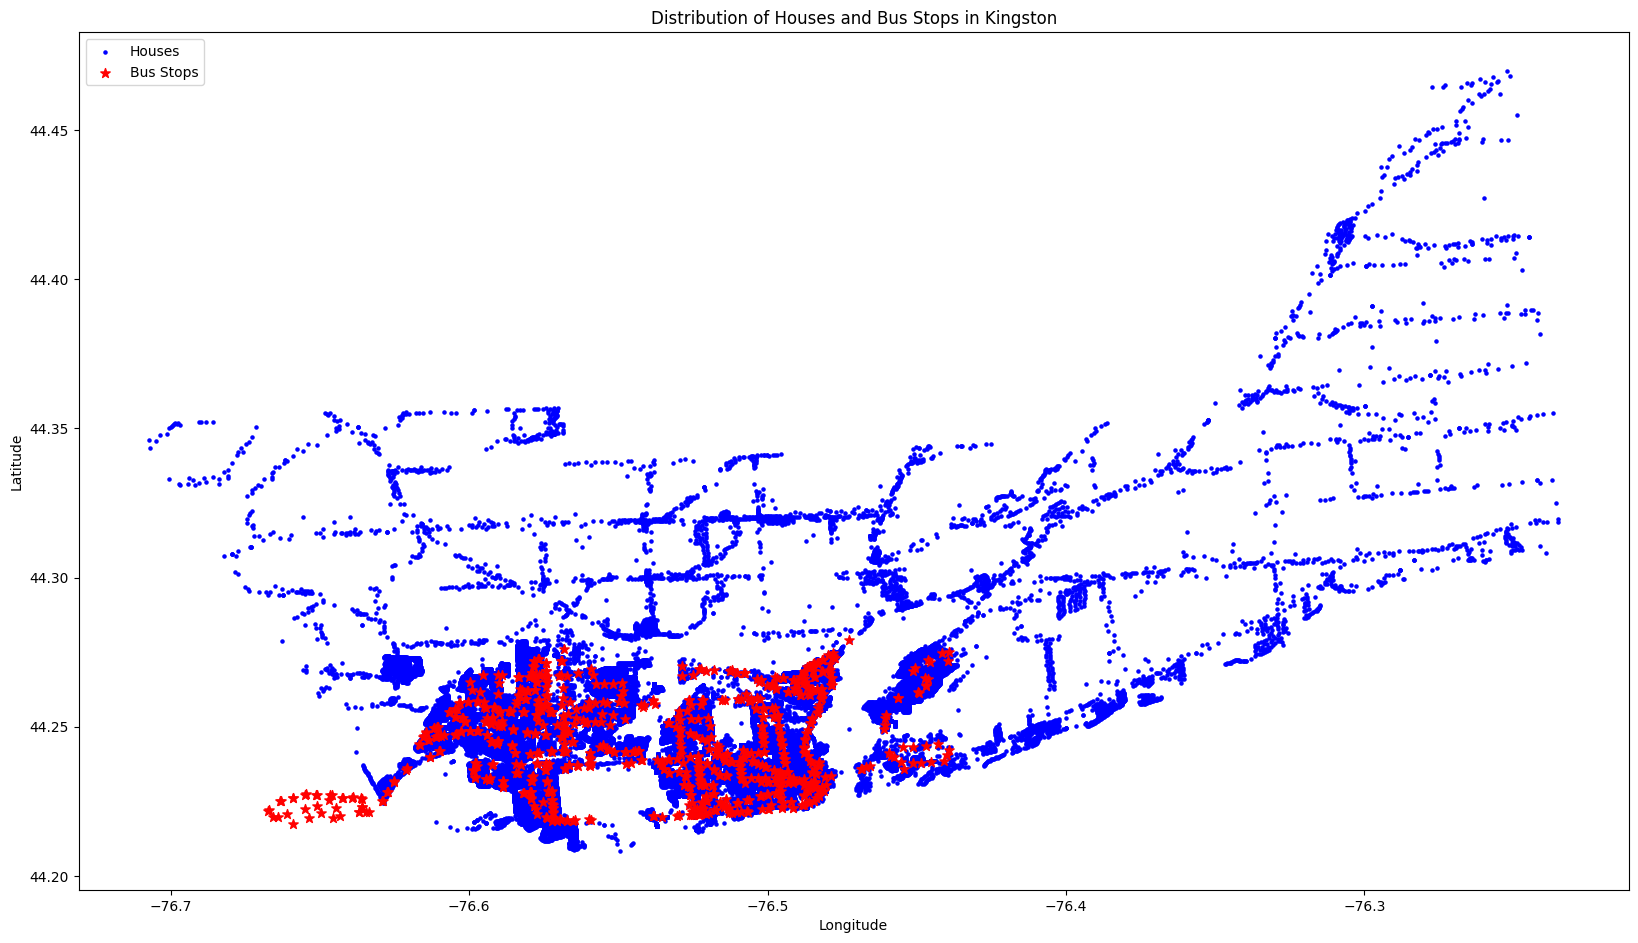

In [267]:
import geopandas as gpd
import matplotlib.pyplot as plt
gdf_houses = gpd.GeoDataFrame(house_address_data, geometry=gpd.points_from_xy(house_address_data.longitude, house_address_data.latitude))
gdf_bus_stops = gpd.GeoDataFrame(bus_stops_data, geometry=gpd.points_from_xy(bus_stops_data.longitude, bus_stops_data.latitude))
fig, ax = plt.subplots(figsize=(20, 20))
gdf_houses.plot(ax=ax, color='blue', markersize=5, label='Houses')
gdf_bus_stops.plot(ax=ax, color='red', marker='*', markersize=50, label='Bus Stops')
ax.set_title('Distribution of Houses and Bus Stops in Kingston')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.show()

C:\Users\Ethan Davis\AppData\Local\Temp\ipykernel_25252\2835280263.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(bus_routes_data))


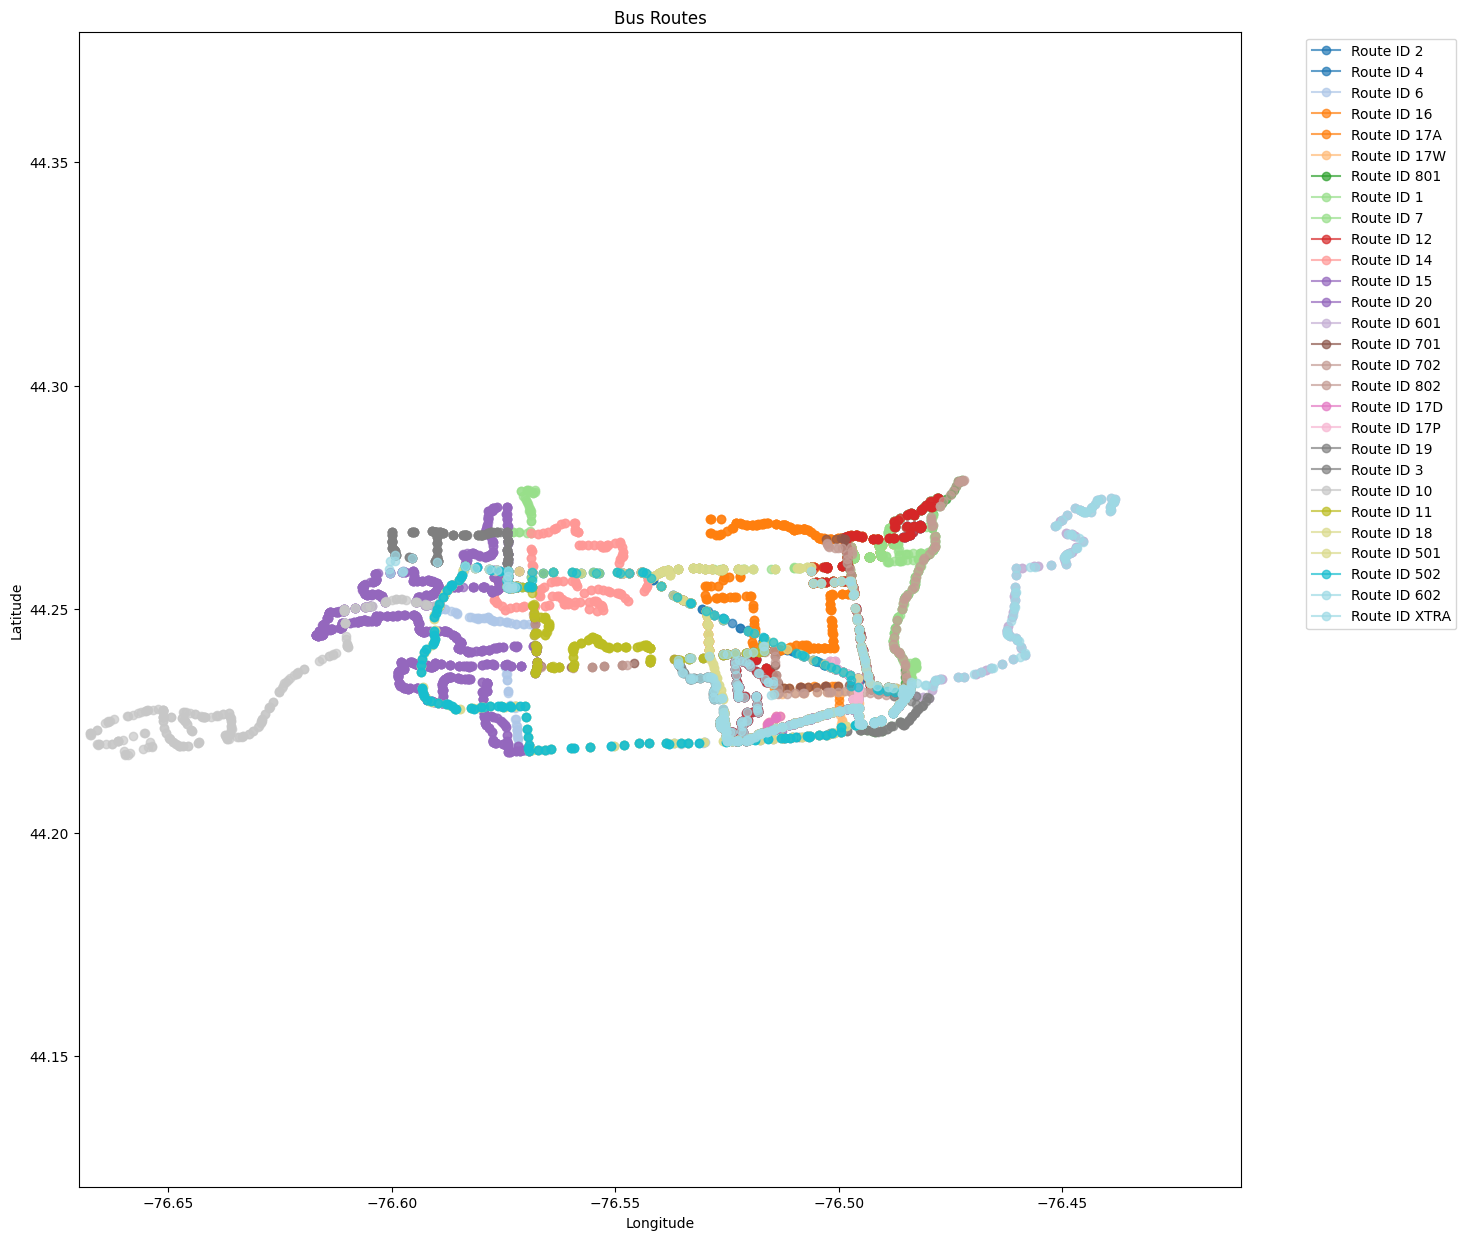

In [268]:
import re

bus_routes_data = pd.read_csv('transit-gtfs-routes.csv')

plt.figure(figsize=(15, 15))

colormap = plt.cm.get_cmap('tab20', len(bus_routes_data))

def parse_coordinates(coord_str):
    coord_pairs = re.findall(r'\[([\d.-]+),\s*([\d.-]+)\]', coord_str)
    if coord_pairs:
        longitudes, latitudes = zip(*[(float(lon), float(lat)) for lon, lat in coord_pairs])
        return longitudes, latitudes
    return [], []

legend_handles = []

for idx, (route_id, route_str) in enumerate(zip(bus_routes_data['ID'], bus_routes_data['Route'])):
    route_segments = route_str.strip('[]').split('],[')
    for segment_idx, segment in enumerate(route_segments):
        segment = '[' + segment + ']'
        longitudes, latitudes = parse_coordinates(segment)
        if longitudes and latitudes:
            line, = plt.plot(longitudes, latitudes, color=colormap(idx), marker='o', linestyle='-', alpha=0.7)
            if segment_idx == 0:
                legend_handles.append(line)

plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bus Routes')
plt.legend(handles=legend_handles, labels=[f'Route ID {rid}' for rid in bus_routes_data['ID']], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(-76.67, -76.41)
plt.ylim(44.2, 44.3)
plt.show()

C:\Users\Ethan Davis\AppData\Local\Temp\ipykernel_25252\1549374515.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('hsv', len(gdf_bus_routes) + 1)  # +1 to avoid using the last color, which is similar to the first


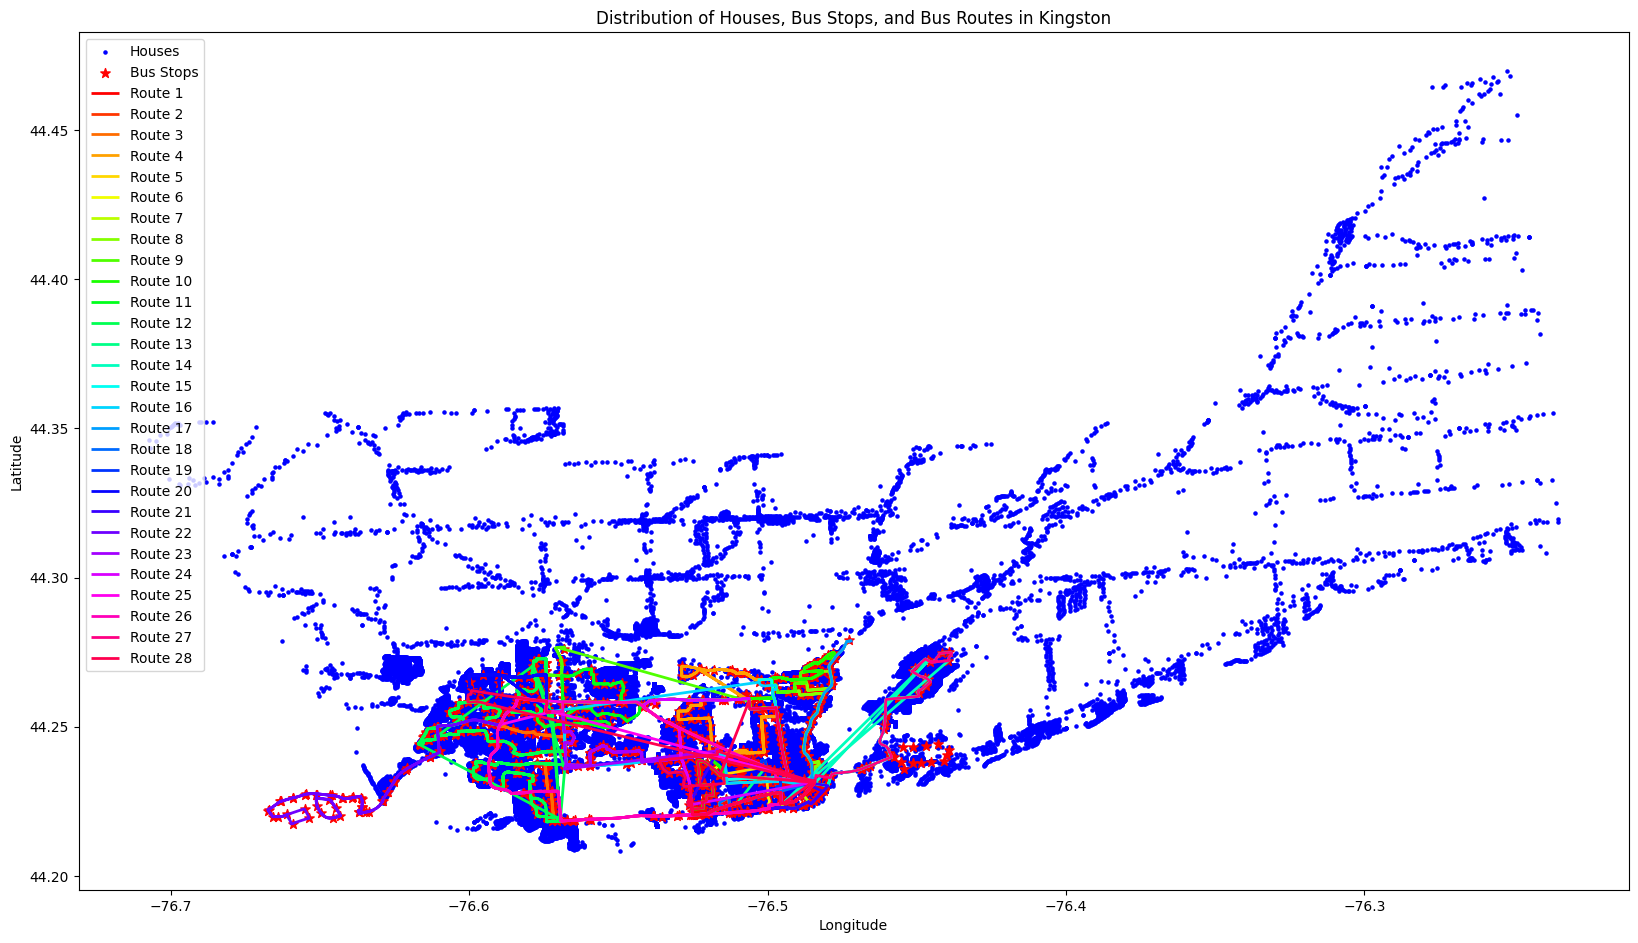

In [269]:
from shapely.geometry import LineString, Point

gdf_houses = gpd.GeoDataFrame(house_address_data, geometry=gpd.points_from_xy(house_address_data.longitude, house_address_data.latitude))
gdf_bus_stops = gpd.GeoDataFrame(bus_stops_data, geometry=gpd.points_from_xy(bus_stops_data.longitude, bus_stops_data.latitude))

fig, ax = plt.subplots(figsize=(20, 20))


gdf_houses.plot(ax=ax, color='blue', markersize=5, label='Houses')
gdf_bus_stops.plot(ax=ax, color='red', marker='*', markersize=50, label='Bus Stops')


def parse_coordinates(coord_str):
    coord_pairs = re.findall(r'\[([\d.-]+),\s*([\d.-]+)\]', coord_str)
    if coord_pairs:
        points = [Point(float(lon), float(lat)) for lon, lat in coord_pairs]
        return LineString(points)
    return None

bus_lines = bus_routes_data['Route'].apply(parse_coordinates)
gdf_bus_routes = gpd.GeoDataFrame(geometry=bus_lines)

colormap = plt.cm.get_cmap('hsv', len(gdf_bus_routes) + 1) 
for idx, line in enumerate(gdf_bus_routes.geometry):
    if line is not None:  
        gpd.GeoSeries([line]).plot(ax=ax, linewidth=2, color=colormap(idx), label=f'Route {idx+1}')

ax.set_title('Distribution of Houses, Bus Stops, and Bus Routes in Kingston')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.legend()
plt.show()